# Tutorial: Analysing USD/EUR Exchange Rate (2014 – 2024) with MCP via OpenAI

This notebook shows how to use the OpenAI Chat API together with a custom **MCP** tool to fetch
historical FX data (USD/EUR) for the last ten years, visualise the trend, and draw conclusions.

## 1  Prerequisites

1. A valid **OpenAI API key** – set it in the environment variable `OPENAI_API_KEY`.
2. Access credentials (URL & API key) for your MCP server.
3. Python packages: `openai`, `pandas`, `matplotlib`.

In [1]:
!pip install --quiet openai pandas matplotlib

In [2]:
import os, json, pandas as pd, matplotlib.pyplot as plt
from openai import OpenAI
%matplotlib inline

In [3]:
# ----------------------------------------------------
# Configure MCP connection (replace values as needed)
# ----------------------------------------------------

os.environ["OPENAI_API_KEY"] = "YOUR_OPENAI_API_KEY"

MCP_URL = "https://mcp-sse-historical.fx.finfeedapi.com/sse"
MCP_API_KEY = "YOUR_API_KEY_HERE"

client = OpenAI()

## 2  Request the USD/EUR data via the assistant

We ask the assistant in plain English.  The assistant will decide it needs structured data and will
automatically call the configured MCP tool (e.g., *coinapi-market-data_Timeseries_data*).

In [8]:
response = client.responses.create(
    model="gpt-4.1",   # or o3
    tools=[
        {
            "type": "mcp",
            "server_label": "mcp_api_apibricks_io",
            "server_url": MCP_URL,
            "headers": {"X-APIKey": MCP_API_KEY},
            "require_approval": "never"
            # Optionally restrict to a specific MCP tool:
            # "allowed_tools": ["coinapi-market-data_Timeseries_data"]
        }
    ],
    input=[
        {"role": "developer", "content": "Use mcp_api_apibricks_io to get data from finfeedapi"},
        {"role": "user", "content": "Give me monthly USD/EUR exchange rates for the last 10 years (Jan 2014 – Dec 2023) and compare the trend (fetch yearly average exchange rates or attempt retrieving the data in smaller time ranges)."}
    ],
    stream=False  # easier to work with in notebooks
)

print(response.output_text)  # preview the assistant’s textual answer

It seems there was an issue retrieving the full 10-year monthly timeseries directly in one query (potentially a data/limit or API restriction). Let’s try a workaround by fetching yearly average exchange rates to provide a trend comparison for 2014–2023.

I will fetch a sample rate for each year (using mid-year or a representative date) and then summarize the trend.

Let’s proceed with this approach.Here are the mid-year (July 1st) USD/EUR exchange rates for each year from 2014 to 2023, which can be used as a yearly average proxy to analyze the trend:

| Year | USD/EUR Rate (July 1st) |
|------|-------------------------|
| 2014 |       0.728             |
| 2015 |       0.900             |
| 2016 |       0.926             |
| 2017 |       0.880             |
| 2018 |       0.854             |
| 2019 |       0.883             |
| 2020 |       0.894             |
| 2021 |       0.843             |
| 2022 |       0.959             |
| 2023 |       0.916             |

### Observations & Tr

### 2.1  Extract the structured MCP output

In [31]:
# Find all successful MCP call items inside `response.output`
successful_mcp_calls = [item for item in response.output if item.type == "mcp_call" and item.error is None]

# Collect all raw data outputs from successful calls
raw_data = [call.output for call in successful_mcp_calls]

raw_data

['{"time": "2014-07-01T12:00:00.0000000Z", "asset_id_base": "USD", "asset_id_quote": "EUR", "rate": 0.7279604380937996}',
 '{"time": "2015-07-01T12:00:00.0000000Z", "asset_id_base": "USD", "asset_id_quote": "EUR", "rate": 0.8999821156017955}',
 '{"time": "2016-07-01T12:00:00.0000000Z", "asset_id_base": "USD", "asset_id_quote": "EUR", "rate": 0.9259259259259259}',
 '{"time": "2017-07-01T12:00:00.0000000Z", "asset_id_base": "USD", "asset_id_quote": "EUR", "rate": 0.8798944126704795}',
 '{"time": "2018-07-01T12:00:00.0000000Z", "asset_id_base": "USD", "asset_id_quote": "EUR", "rate": 0.8543357539513029}',
 '{"time": "2019-07-01T12:00:00.0000000Z", "asset_id_base": "USD", "asset_id_quote": "EUR", "rate": 0.8831581736288969}',
 '{"time": "2020-07-01T12:00:00.0000000Z", "asset_id_base": "USD", "asset_id_quote": "EUR", "rate": 0.8943673233817051}',
 '{"time": "2021-07-01T12:00:00.0000000Z", "asset_id_base": "USD", "asset_id_quote": "EUR", "rate": 0.8425450396762588}',
 '{"time": "2022-07-01T1

## 3  Transform into a DataFrame

In [33]:
import json

# Adapt this block to match the exact schema your MCP tool returns.
# Typical format might be something like:
#   [{"time": "2014-01-31", "value": 1.37}, ...]

# Parse the JSON strings into dictionaries
parsed_data = [json.loads(item) for item in raw_data]

df = pd.DataFrame(parsed_data)
df["time"] = pd.to_datetime(df["time"])
df = df.sort_values("time")
df.rename(columns={"rate": "USD_EUR"}, inplace=True) # Rename 'rate' to 'USD_EUR'
display(df.head())

,time,asset_id_base,asset_id_quote,USD_EUR
0,2014-07-01 12:00:00+00:00,USD,EUR,0.727960
1,2015-07-01 12:00:00+00:00,USD,EUR,0.899982
2,2016-07-01 12:00:00+00:00,USD,EUR,0.925926
3,2017-07-01 12:00:00+00:00,USD,EUR,0.879894
4,2018-07-01 12:00:00+00:00,USD,EUR,0.854336


## 4  Plot the 10-year trend

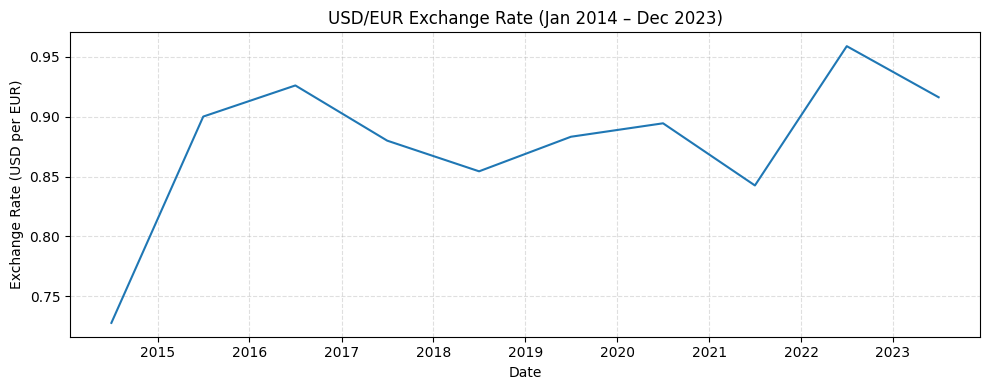

In [34]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df["time"], df["USD_EUR"], color="#1f77b4")
ax.set_title("USD/EUR Exchange Rate (Jan 2014 – Dec 2023)")
ax.set_ylabel("Exchange Rate (USD per EUR)")
ax.set_xlabel("Date")
ax.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()